### Converting XML (Graphs) to nt format. 

In [2]:
import rdflib
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import numpy as np
import sklearn


In [13]:
# for file in glob.glob('data/xml/*.xml'):
#     filename = file.split('/')[2].split('.')[0]
#     g = rdflib.Graph()
#     g.parse(file, format='xml')
#     g.serialize(destination='data/nt/'+filename+'.nt', format='nt')
#     print(filename+' is stored.')

### Processing PARIS outputs

For now, we are converting PARIS generated superrelation.csv files
* n_superrelations1.tsv :
   Relations of ontology 1 that are superrelations of relations of ontology 2
* n_superrelations2.tsv :
   Relations of ontology 2 that are superrelations of relations of ontology 1

In [2]:
def load_paris_sim(file):
    file = pd.read_csv(file, sep='\t', header=None)
    file.columns = ['r1', 'r2', 'Score']
    
    indexes = set(file['r1'])
    columns = set(file['r2'])
    relational_similarity = pd.DataFrame(columns=columns, index=indexes)

    '''
    relational similarity df index: starwars
    relational similarity df columns: starwars_tor
    '''
    
    for row in file.iterrows():
        index, triple = row
        relational_similarity[triple['r2']][triple['r1']] = triple['Score']
    
    relational_similarity = relational_similarity.fillna(0)

    return relational_similarity

### Processing WIKI GT dataset

In [3]:
def mod_name(str_list):
    temp_arr = []
    for each in str_list:
        temp = each.split('/')
        temp_arr.append(temp[3].split('.')[0]+'/'+temp[5])
        
    return temp_arr

In [4]:
def generate_roc(file1, file2, relational_similarity_PARIS):
    relations_df1 = pd.read_csv(file1, header=None)
    relations_df2 = pd.read_csv(file2, header=None)
    
    relational_similarity_GT = pd.DataFrame(index=list(relations_df1[0]), columns=list(relations_df2[0]))
    
    for c in relational_similarity_GT.columns:
        if c in relational_similarity_PARIS.columns:
            for i in relational_similarity_GT.index:
                if i in relational_similarity_PARIS.index:
                    relational_similarity_GT.loc[i,c] = relational_similarity_PARIS.loc[i,c]

    relational_similarity_GT = relational_similarity_GT.fillna(0)

    index_name = mod_name(relational_similarity_GT.index)
    columns_name = mod_name(relational_similarity_GT.columns)

    plt.figure(figsize=(10,10))
    sns.set(font_scale=1)
    sns.heatmap(relational_similarity_GT, annot=False, annot_kws={"size": 8}, cmap=sns.diverging_palette(0, 500, n=200),\
              yticklabels=index_name, xticklabels=columns_name)
    plt.savefig('test.pdf')

    plt.show()

    similarity_GT = pd.DataFrame(columns=['G1_relation', 'G2_relation', 'Similarity_value', 'True_value'])

    for i in range(len(relations_df1)):
        for c in range(len(relations_df2)):
            true_value=0
            if i==c:
                true_value=1
            similarity_GT = similarity_GT.append({'G1_relation':relations_df1.iloc[i,0], 'G2_relation':relations_df2.iloc[c,0], \
                                                  'Similarity_value':relational_similarity_GT.iloc[i,c], \
                                                  'True_value':float(true_value)}, ignore_index=True)

    y = np.array(similarity_GT[['True_value']])
    pred_y = np.array(similarity_GT[['Similarity_value']])
    fpr, tpr, threshold = roc_curve(y, pred_y)
    roc_auc = sklearn.metrics.auc(fpr, tpr)

    plt.figure()
    lw = 1
    plt.plot(fpr, tpr, color='darkgreen',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0,1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.savefig('test2.pdf')
    plt.show()
    
    

#### Convert ground truth data to relational similarity matrix 
Similarity between relation set 1 and relation set 2 <br />
Takes relation set 1 and relation set 2 and generates ground truth confusion matrix between the two set of relations.

In [5]:
def generate_GT_similarity(file1, file2, relational_similarity_PARIS):
    relations_df1 = pd.read_csv(file1, header=None)
    relations_df2 = pd.read_csv(file2, header=None)
    
    relational_similarity_GT = pd.DataFrame(index=list(relations_df1[0]), columns=list(relations_df2[0]))
    
    for c in relational_similarity_GT.columns:
        if c in relational_similarity_PARIS.columns:
            for i in relational_similarity_GT.index:
                if i in relational_similarity_PARIS.index:
                    relational_similarity_GT.loc[i,c] = relational_similarity_PARIS.loc[i,c]

    relational_similarity_GT = relational_similarity_GT.fillna(0)

    index_name = mod_name(relational_similarity_GT.index)
    columns_name = mod_name(relational_similarity_GT.columns)
    
    similarity_GT = pd.DataFrame(columns=['G1_relation', 'G2_relation', 'Similarity_value', 'True_value'])

    for i in range(len(relations_df1)):
        for c in range(len(relations_df2)):
            true_value=0
            if i==c:
                true_value=1
            similarity_GT = similarity_GT.append({'G1_relation':relations_df1.iloc[i,0], 'G2_relation':relations_df2.iloc[c,0], \
                                                  'Similarity_value':relational_similarity_GT.iloc[i,c], \
                                                  'True_value':float(true_value)}, ignore_index=True)

    return similarity_GT

Loading super-relation1, super-relation2 and their product ( super-relation1 * super-relation2)

In [6]:
def load_all_superrelations():
    
    superrelations1 = load_paris_sim('output/swVsSwTor/9_superrelations1.tsv')
    superrelations2 = load_paris_sim('output/swVsSwTor/9_superrelations2.tsv')
    rel_sim_product = relational_similarity_product('output/swVsSwTor/9_superrelations1.tsv','output/swVsSwTor/9_superrelations2.tsv')

    gt1 = generate_GT_similarity('data/relations/starwars_relations.txt', 'data/relations/starwars_tor_relations.txt', \
                 relational_similarity_PARIS = superrelations1)
    gt2 = generate_GT_similarity('data/relations/starwars_tor_relations.txt', 'data/relations/starwars_relations.txt', \
                               relational_similarity_PARIS = superrelations2)
    gt3 = generate_GT_similarity('data/relations/starwars_relations.txt', 'data/relations/starwars_tor_relations.txt', rel_sim_product)

    gt = {}
    gt[1] = gt1
    gt[2] = gt2
    gt[3] = gt3

In [51]:
def plot_mult_roc(gt, label):

    fpr = []
    tpr = []
    threshold = []
    roc_auc = []

    for i in range(1,6):
        similarity_GT = gt[i]
        y = np.array(similarity_GT[['True_value']])
        pred_y = np.array(similarity_GT[['Similarity_value']])
        _fpr, _tpr, _threshold = roc_curve(y, pred_y)
        _roc_auc = sklearn.metrics.auc(_fpr, _tpr)
        fpr.append(_fpr)
        tpr.append(_tpr)
        threshold.append(_threshold)
        roc_auc.append(_roc_auc)


    plt.figure()
    lw = 1
    colors = ['red', 'orange', 'blue', 'green', 'purple']
    labels = ['Super-relation 1', 'Super-relation 2', 'Product', 'Approach 1', 'Approach 2']

    for i in range(5):
        plt.plot(fpr[i], tpr[i], color=colors[i],
                 lw=lw, label='{} = {}'.format(labels[i], "{0:.2f}".format(roc_auc[i])))
        plt.plot([0, 1], [0,1], color='navy', lw=lw, linestyle='--')

    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right") 
    plt.show()
    plt.savefig(label+'.png')

### [Super-relations 1] * [Super-relations 2]

In [8]:
def relational_similarity_product(superrelations1, superrelations2):
    superrelations1 = load_paris_sim(superrelations1)
    superrelations2 = load_paris_sim(superrelations2)

    relation_set_1 = set(list(superrelations1.index) + list(superrelations2.columns))
    relation_set_2 = set(list(superrelations1.columns) + list(superrelations2.index))

    rel_sim_product = pd.DataFrame(index=relation_set_1, columns=relation_set_2)

    for r in relation_set_1:
        for c in relation_set_2:
            if r in superrelations1.index and r in superrelations2.columns and c in superrelations1.columns and c in superrelations2.index:
                product = superrelations1[c][r] * superrelations2[r][c]
                if product>0:
                    rel_sim_product[c][r] = product
                else:
                    rel_sim_product[c][r] = max(superrelations1[c][r], superrelations2[r][c])

    rel_sim_product = rel_sim_product.fillna(0)
    
    return rel_sim_product


##### Starwars vs starwars_tor

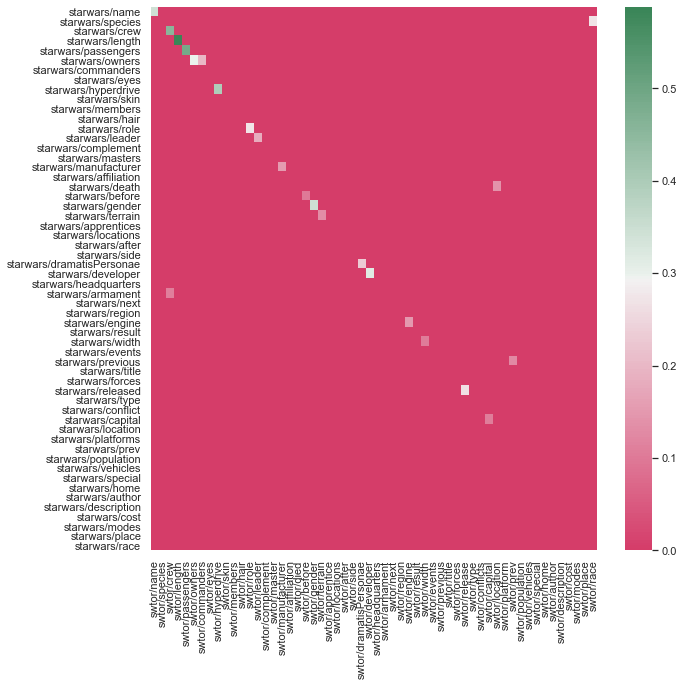

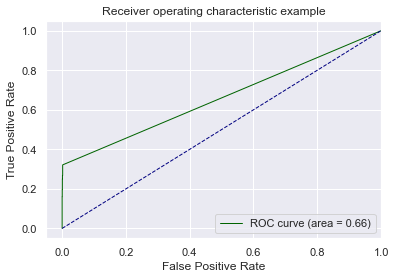

In [27]:
superrelations1 = load_paris_sim('output/swVsSwTor/9_superrelations1.tsv')
generate_roc('data/relations/starwars_relations.txt', 'data/relations/starwars_tor_relations.txt', \
             relational_similarity_PARIS = superrelations1)

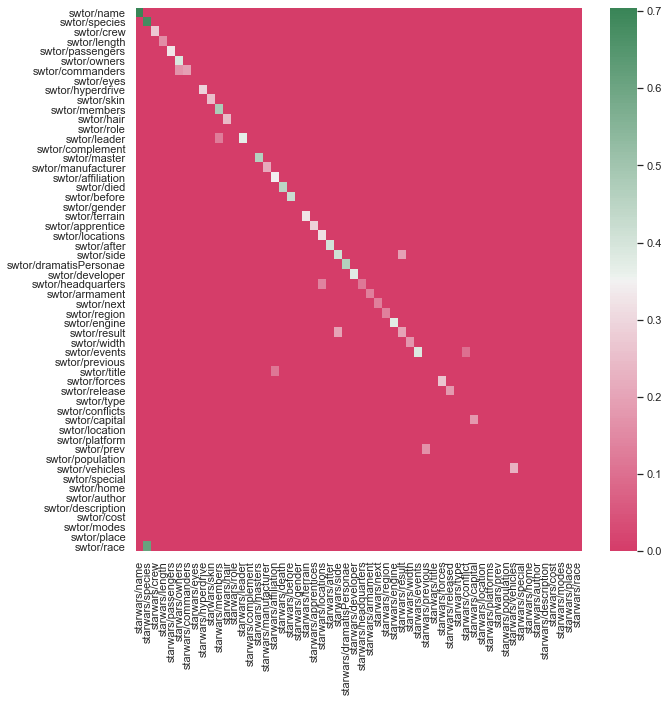

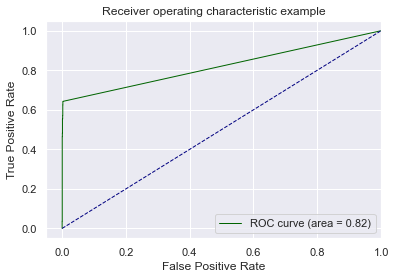

In [30]:
superrelations2 = load_paris_sim('output/swVsSwTor/9_superrelations2.tsv')
generate_roc('data/relations/starwars_tor_relations.txt', 'data/relations/starwars_relations.txt', \
                           relational_similarity_PARIS = superrelations2)

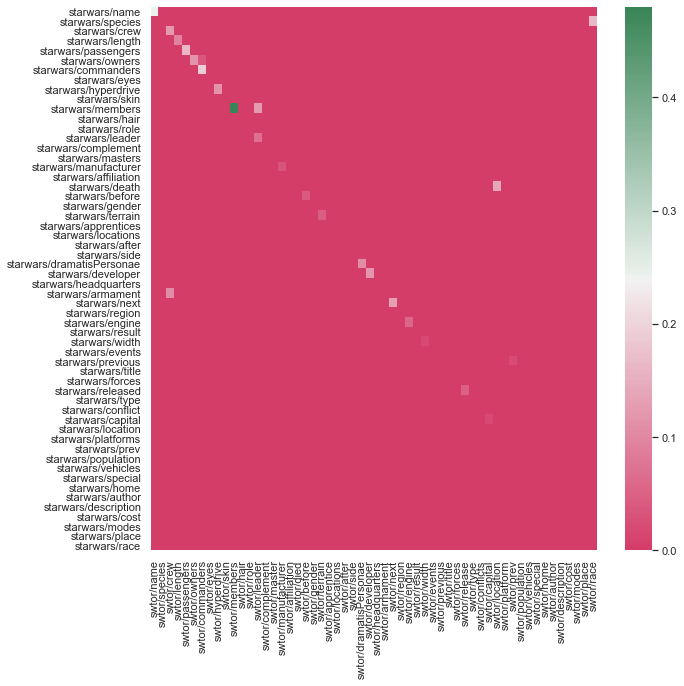

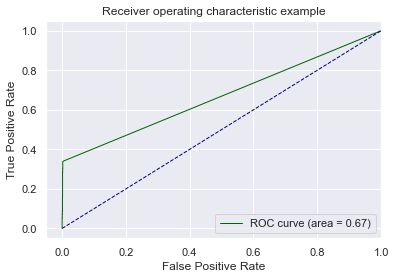

In [31]:
rel_sim_product = relational_similarity_product('output/swVsSwTor/9_superrelations1.tsv','output/swVsSwTor/9_superrelations2.tsv')
generate_roc('data/relations/starwars_relations.txt', 'data/relations/starwars_tor_relations.txt', rel_sim_product)

In [44]:
gt_approach_1_jaccard = pd.read_csv('data/relational_similarity/sw_vs_sw_tor_1.csv', index_col=0)
gt_approach_2_own = pd.read_csv('data/relational_similarity/sw_vs_sw_tor_2.csv', index_col=0)

In [45]:
superrelations1 = load_paris_sim('output/swVsSwTor/9_superrelations1.tsv')
gt1 = generate_GT_similarity('data/relations/starwars_relations.txt', 'data/relations/starwars_tor_relations.txt', \
             relational_similarity_PARIS = superrelations1)
superrelations2 = load_paris_sim('output/swVsSwTor/9_superrelations2.tsv')
gt2 = generate_GT_similarity('data/relations/starwars_tor_relations.txt', 'data/relations/starwars_relations.txt', \
                           relational_similarity_PARIS = superrelations2)
rel_sim_product = relational_similarity_product('output/swVsSwTor/9_superrelations1.tsv','output/swVsSwTor/9_superrelations2.tsv')
gt3 = generate_GT_similarity('data/relations/starwars_relations.txt', 'data/relations/starwars_tor_relations.txt', rel_sim_product)


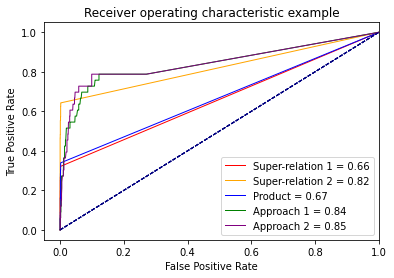

<Figure size 432x288 with 0 Axes>

In [52]:
gt = {}
gt[1] = gt1
gt[2] = gt2
gt[3] = gt3
gt[4] = gt_approach_1_jaccard
gt[5] = gt_approach_2_own

plot_mult_roc(gt, 'sw_vs_sw_tor')

##### Memory alpha vs memory beta


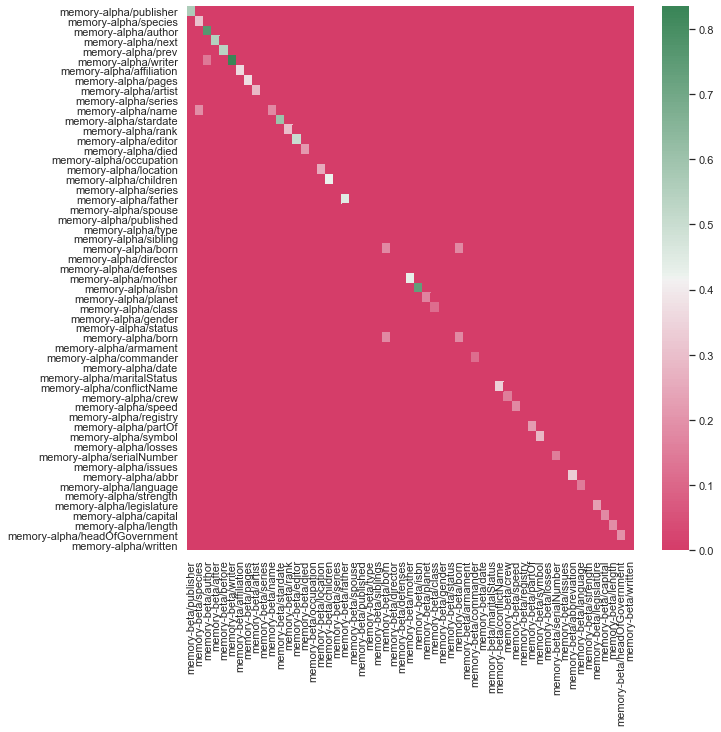

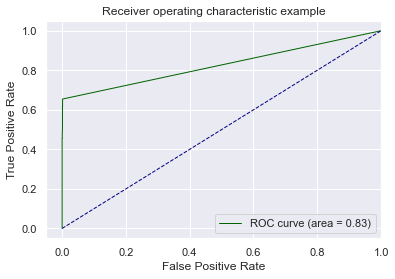

In [33]:
superrelations1 = load_paris_sim('output/memoryAlphaVsBeta/9_superrelations1.tsv')
generate_roc('data/relations/memory_alpha_relations.txt', 'data/relations/memory_beta_relations.txt', \
             relational_similarity_PARIS = superrelations1)

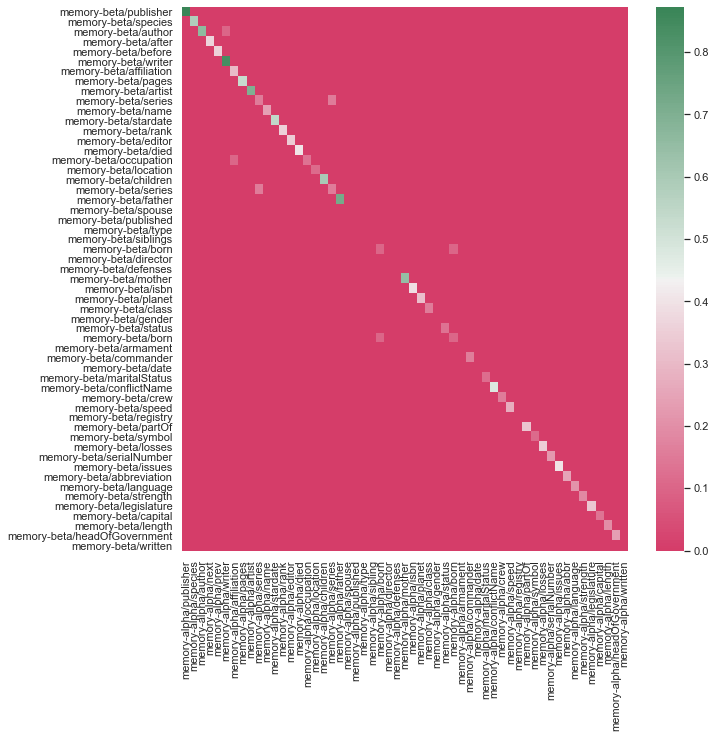

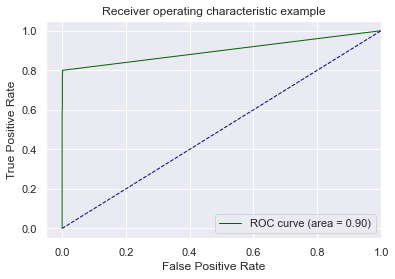

In [34]:
superrelations2 = load_paris_sim('output/memoryAlphaVsBeta/9_superrelations2.tsv')
generate_roc('data/relations/memory_beta_relations.txt', 'data/relations/memory_alpha_relations.txt', \
             relational_similarity_PARIS = superrelations2)

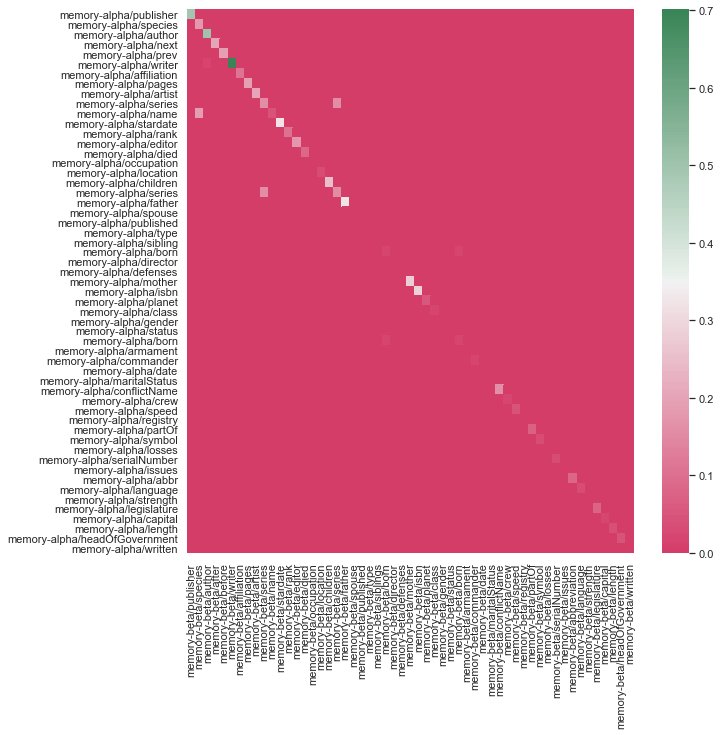

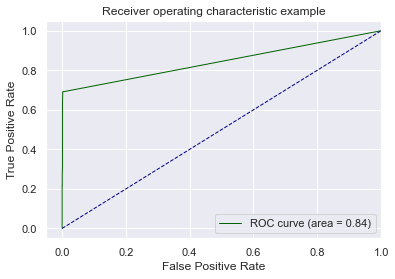

In [37]:
rel_sim_product = relational_similarity_product('output/memoryAlphaVsBeta/9_superrelations1.tsv','output/memoryAlphaVsBeta/9_superrelations2.tsv')
generate_roc('data/relations/memory_alpha_relations.txt', 'data/relations/memory_beta_relations.txt', \
             relational_similarity_PARIS = rel_sim_product)

In [26]:
gt_approach_1_jaccard = pd.read_csv('data/relational_similarity/memory_alpha_vs_beta_1.csv', index_col=0)
gt_approach_2_own = pd.read_csv('data/relational_similarity/memory_alpha_vs_beta_2.csv', index_col=0)

In [27]:
superrelations1 = load_paris_sim('output/memoryAlphaVsBeta/9_superrelations1.tsv')
gt1 = generate_GT_similarity('data/relations/memory_alpha_relations.txt', 'data/relations/memory_beta_relations.txt', \
             relational_similarity_PARIS = superrelations1)
superrelations2 = load_paris_sim('output/memoryAlphaVsBeta/9_superrelations2.tsv')
gt2 = generate_GT_similarity('data/relations/memory_beta_relations.txt', 'data/relations/memory_alpha_relations.txt', \
             relational_similarity_PARIS = superrelations2)
rel_sim_product = relational_similarity_product('output/memoryAlphaVsBeta/9_superrelations1.tsv','output/memoryAlphaVsBeta/9_superrelations2.tsv')
gt3 = generate_GT_similarity('data/relations/memory_alpha_relations.txt', 'data/relations/memory_beta_relations.txt', \
             relational_similarity_PARIS = rel_sim_product)



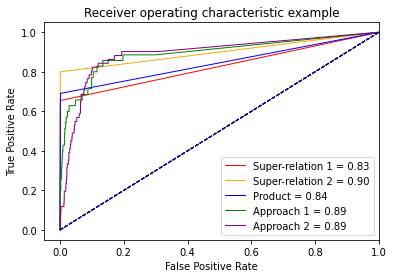

In [28]:
gt = {}
gt[1] = gt1
gt[2] = gt2
gt[3] = gt3
gt[4] = gt_approach_1_jaccard
gt[5] = gt_approach_2_own

plot_mult_roc(gt)

##### Starwars vs starwars galaxies


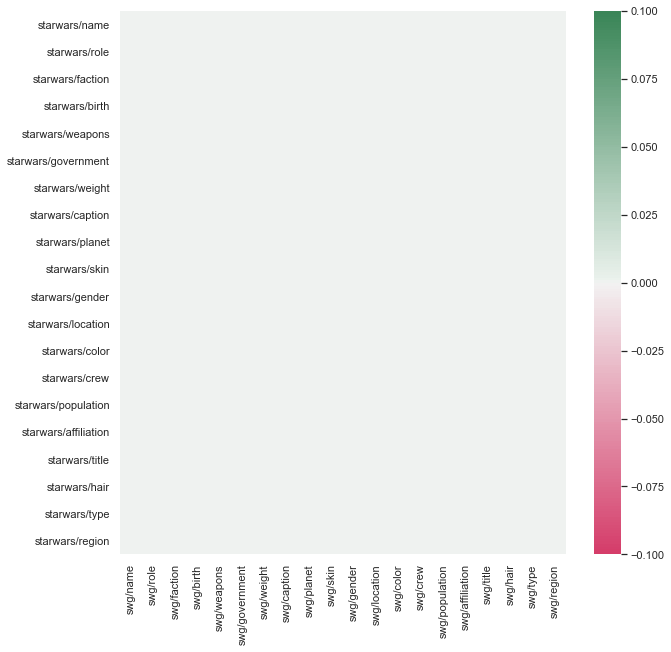

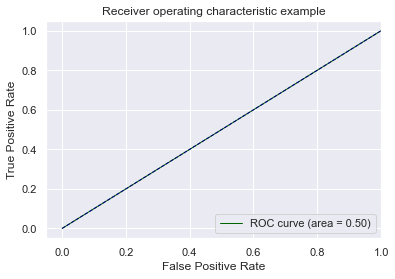

In [40]:
superrelations1 = load_paris_sim('output/swVsSwg/9_superrelations1.tsv')
generate_roc('data/relations/starwars_relations_2.txt', 'data/relations/starwars_galaxies_relations_2.txt', \
             relational_similarity_PARIS = superrelations1)

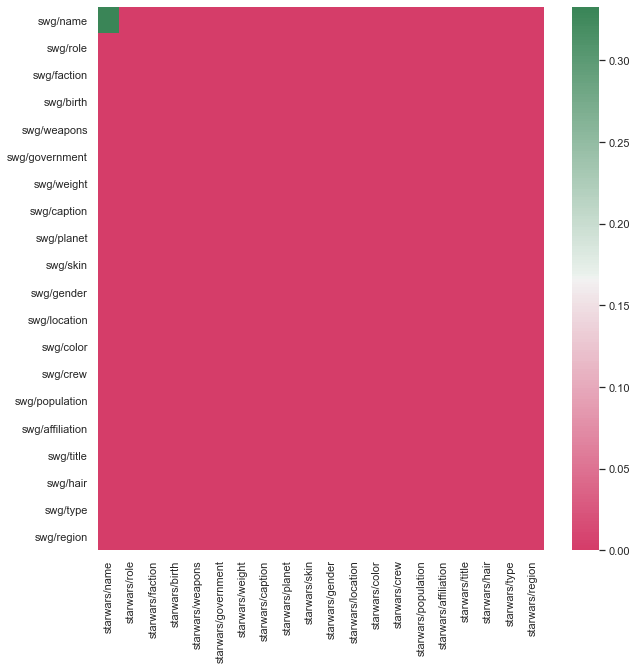

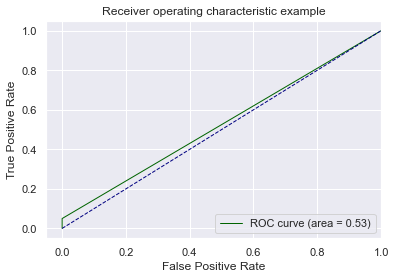

In [41]:
superrelations2 = load_paris_sim('output/swVsSwg/9_superrelations2.tsv')
generate_roc('data/relations/starwars_galaxies_relations_2.txt', 'data/relations/starwars_relations_2.txt',  \
             relational_similarity_PARIS = superrelations2)

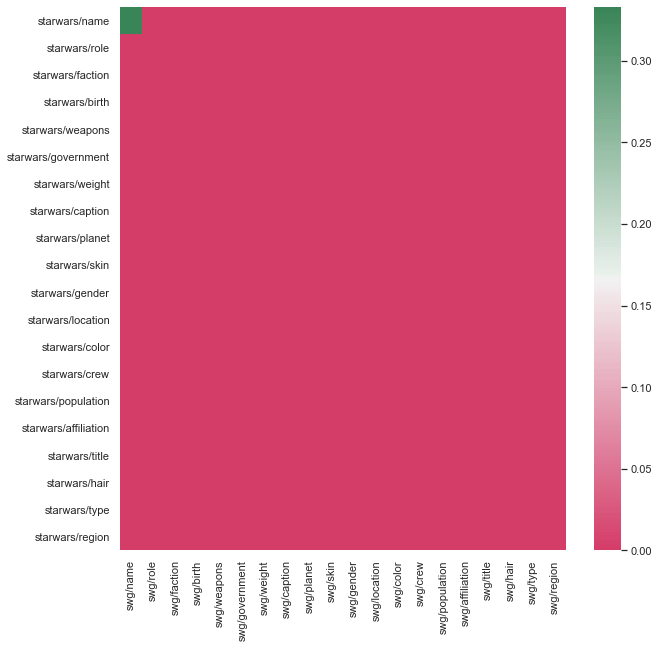

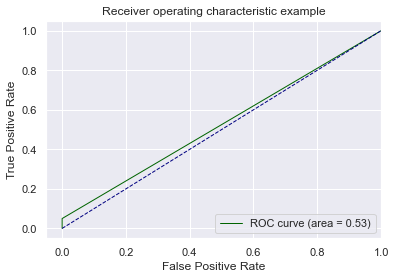

In [43]:
rel_sim_product = relational_similarity_product('output/swVsSwg/9_superrelations1.tsv', 'output/swVsSwg/9_superrelations2.tsv')
generate_roc('data/relations/starwars_relations_2.txt', 'data/relations/starwars_galaxies_relations_2.txt', \
             relational_similarity_PARIS = rel_sim_product)

In [40]:
gt_approach_1_jaccard = pd.read_csv('data/relational_similarity/sw_vs_swg_1.csv', index_col=0)
gt_approach_2_own = pd.read_csv('data/relational_similarity/sw_vs_swg_2.csv', index_col=0)

In [41]:
superrelations1 = load_paris_sim('output/swVsSwg/9_superrelations1.tsv')
gt1 = generate_GT_similarity('data/relations/starwars_relations_2.txt', 'data/relations/starwars_galaxies_relations_2.txt', \
             relational_similarity_PARIS = superrelations1)
superrelations2 = load_paris_sim('output/swVsSwg/9_superrelations2.tsv')
gt2 = generate_GT_similarity('data/relations/starwars_galaxies_relations_2.txt', 'data/relations/starwars_relations_2.txt',  \
             relational_similarity_PARIS = superrelations2)
rel_sim_product = relational_similarity_product('output/swVsSwg/9_superrelations1.tsv', 'output/swVsSwg/9_superrelations2.tsv')
gt3 = generate_GT_similarity('data/relations/starwars_relations_2.txt', 'data/relations/starwars_galaxies_relations_2.txt', \
             relational_similarity_PARIS = rel_sim_product)


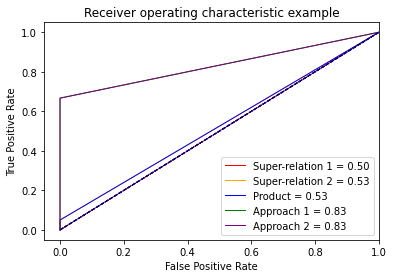

In [42]:
gt = {}
gt[1] = gt1
gt[2] = gt2
gt[3] = gt3
gt[4] = gt_approach_1_jaccard
gt[5] = gt_approach_2_own

plot_mult_roc(gt)

### Memory alpha vs Startrek Expanded ( STExpanded)

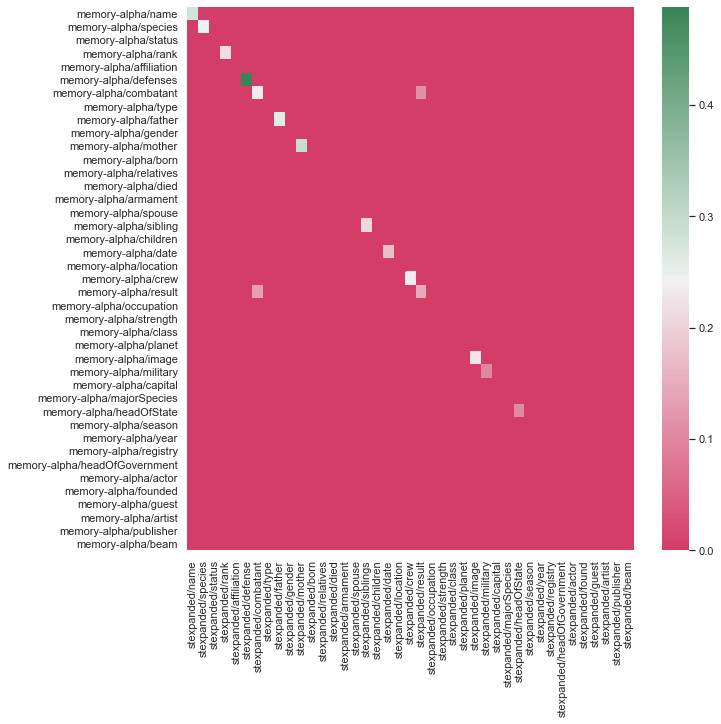

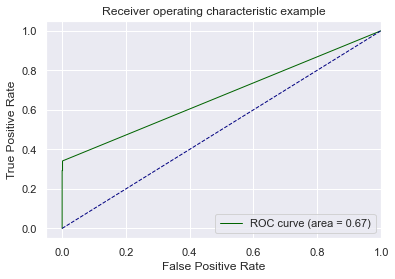

In [49]:
superrelations1 = load_paris_sim('output/memoryAlphaVsSTExpanded/9_superrelations1.tsv')
generate_roc('data/relations/memoryalpha_relations_2.txt', 'data/relations/stexpanded_relations_2.txt', \
             relational_similarity_PARIS = superrelations1)

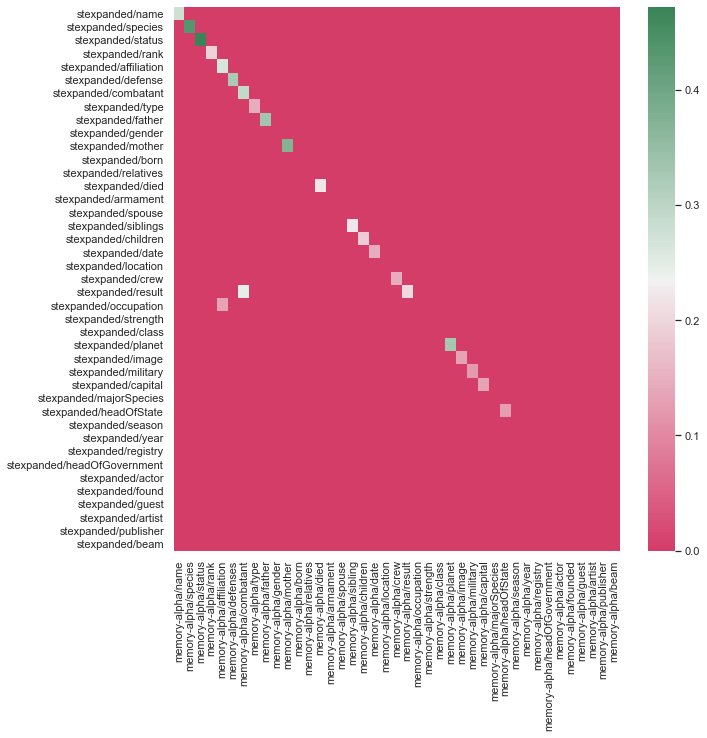

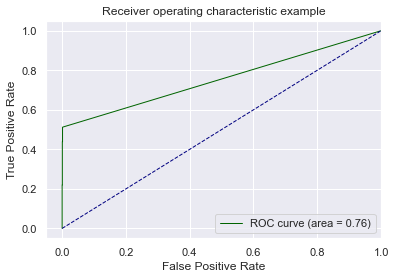

In [50]:
superrelations2 = load_paris_sim('output/memoryAlphaVsSTExpanded/9_superrelations2.tsv')
generate_roc('data/relations/stexpanded_relations_2.txt', 'data/relations/memoryalpha_relations_2.txt', \
             relational_similarity_PARIS = superrelations2)

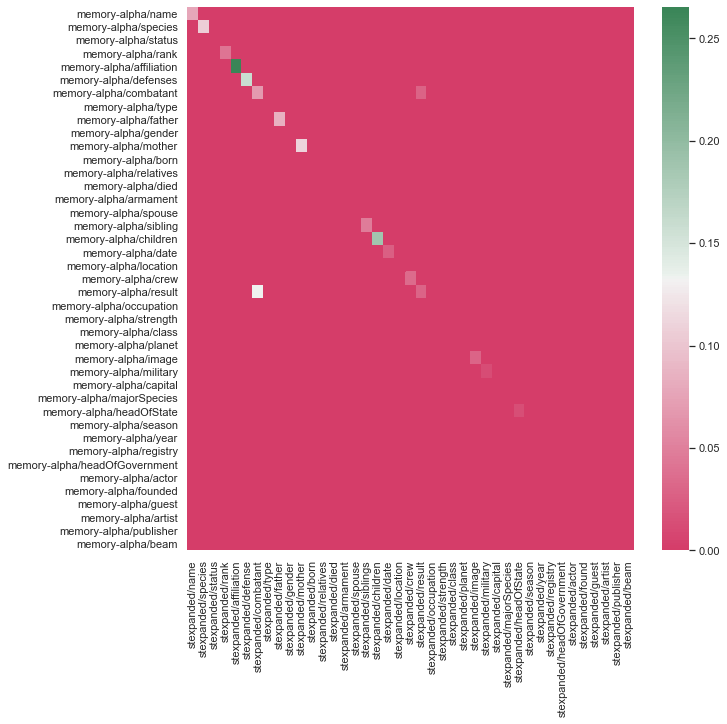

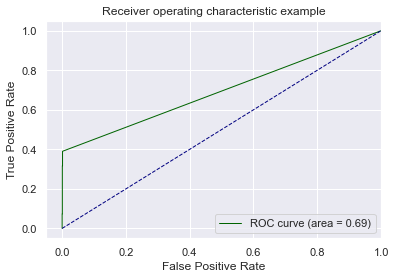

In [51]:
rel_sim_product = relational_similarity_product('output/memoryAlphaVsSTExpanded/9_superrelations1.tsv', 'output/memoryAlphaVsSTExpanded/9_superrelations2.tsv')
generate_roc('data/relations/memoryalpha_relations_2.txt', 'data/relations/stexpanded_relations_2.txt', \
             relational_similarity_PARIS = rel_sim_product)

In [34]:
gt_approach_1_jaccard = pd.read_csv('data/relational_similarity/memory_alpha_vs_stexpanded_1.csv', index_col=0)
gt_approach_2_own = pd.read_csv('data/relational_similarity/memory_alpha_vs_stexpanded_2.csv', index_col=0)

In [30]:
superrelations1 = load_paris_sim('output/memoryAlphaVsSTExpanded/9_superrelations1.tsv')
gt1 = generate_GT_similarity('data/relations/memory_alpha_relations_2.txt', 'data/relations/stexpanded_relations_2.txt', \
             relational_similarity_PARIS = superrelations1)
superrelations2 = load_paris_sim('output/memoryAlphaVsSTExpanded/9_superrelations2.tsv')
gt2 = generate_GT_similarity('data/relations/stexpanded_relations_2.txt', 'data/relations/memory_alpha_relations_2.txt', \
             relational_similarity_PARIS = superrelations2)
rel_sim_product = relational_similarity_product('output/memoryAlphaVsSTExpanded/9_superrelations1.tsv', 'output/memoryAlphaVsSTExpanded/9_superrelations2.tsv')
gt3 = generate_GT_similarity('data/relations/memory_alpha_relations_2.txt', 'data/relations/stexpanded_relations_2.txt', \
             relational_similarity_PARIS = rel_sim_product)


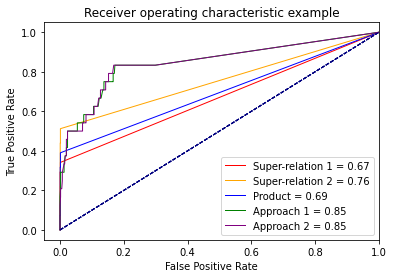

In [35]:
gt = {}
gt[1] = gt1
gt[2] = gt2
gt[3] = gt3
gt[4] = gt_approach_1_jaccard
gt[5] = gt_approach_2_own

plot_mult_roc(gt)

### MarvelCinematicUniverse vs Marvel

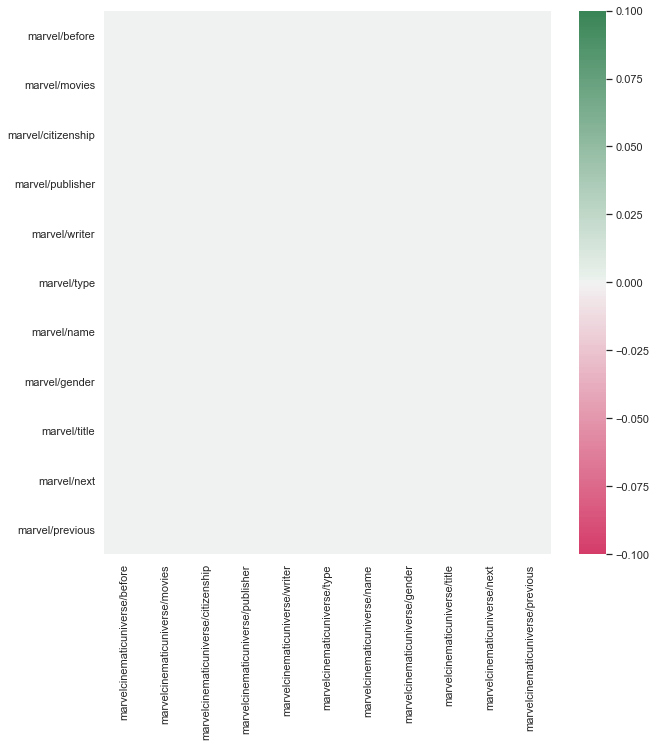

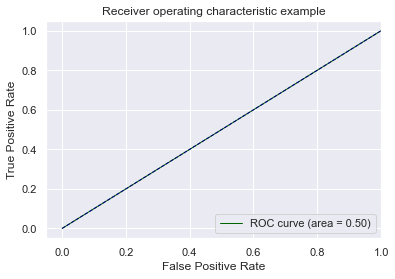

In [54]:
superrelations1 = load_paris_sim('output/marvelVsMarvelCU/9_superrelations1.tsv')
generate_roc('data/relations/marvel_relations.txt', 'data/relations/marvelcinematicuniverse_relations.txt', \
             relational_similarity_PARIS = superrelations1)

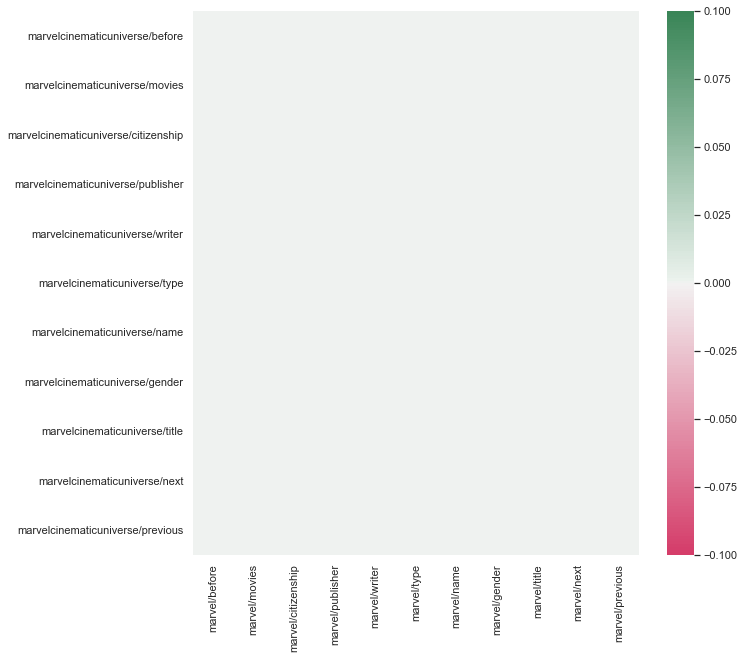

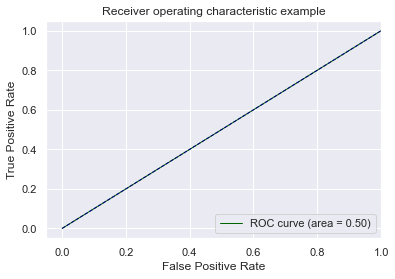

In [55]:
superrelations2 = load_paris_sim('output/marvelVsMarvelCU/9_superrelations2.tsv')
generate_roc('data/relations/marvelcinematicuniverse_relations.txt', 'data/relations/marvel_relations.txt', \
             relational_similarity_PARIS = superrelations2)

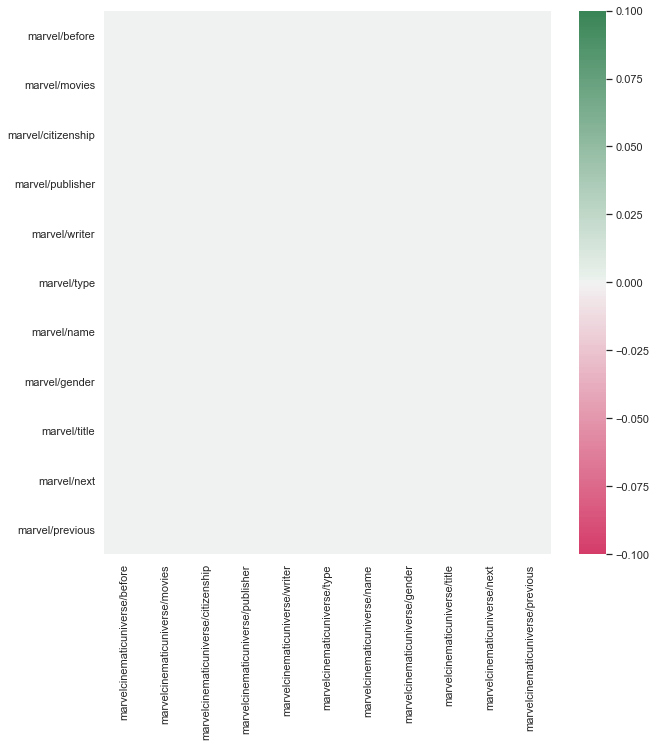

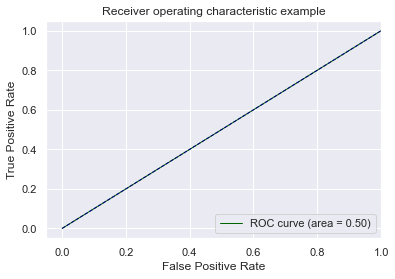

In [122]:
rel_sim_product = relational_similarity_product('output/marvelVsMarvelCU/9_superrelations1.tsv', 'output/marvelVsMarvelCU/9_superrelations2.tsv')
generate_roc('data/relations/marvel_relations.txt', 'data/relations/marvelcinematicuniverse_relations.txt', \
             relational_similarity_PARIS = rel_sim_product)

In [38]:
gt_approach_1_jaccard = pd.read_csv('data/relational_similarity/marvelcinematicuniverse_vs_marvel_2.csv', index_col=0)
gt_approach_2_own = pd.read_csv('data/relational_similarity/marvelcinematicuniverse_vs_marvel_2.csv', index_col=0)

In [37]:
superrelations1 = load_paris_sim('output/marvelVsMarvelCU/9_superrelations1.tsv')
gt1 = generate_GT_similarity('data/relations/marvel_relations.txt', 'data/relations/marvelcinematicuniverse_relations.txt', \
             relational_similarity_PARIS = superrelations1)
superrelations2 = load_paris_sim('output/marvelVsMarvelCU/9_superrelations2.tsv')
gt2 = generate_GT_similarity('data/relations/marvelcinematicuniverse_relations.txt', 'data/relations/marvel_relations.txt', \
             relational_similarity_PARIS = superrelations2)
rel_sim_product = relational_similarity_product('output/marvelVsMarvelCU/9_superrelations1.tsv', 'output/marvelVsMarvelCU/9_superrelations2.tsv')
gt3 = generate_GT_similarity('data/relations/marvel_relations.txt', 'data/relations/marvelcinematicuniverse_relations.txt', \
             relational_similarity_PARIS = rel_sim_product)


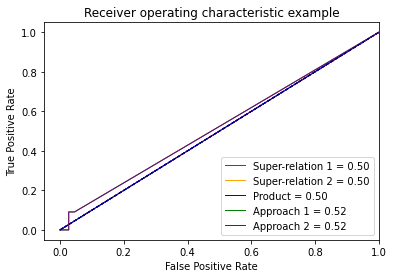

In [39]:
gt = {}
gt[1] = gt1
gt[2] = gt2
gt[3] = gt3
gt[4] = gt_approach_1_jaccard
gt[5] = gt_approach_2_own

plot_mult_roc(gt)

In [3]:
results = pd.read_csv('results_aucs2.csv')
results = results.set_index('Dataset')

In [4]:
results


,Jaccard appraoch,IOP ( 2nd approach ),DPIN,NDPIN,NDPIN ( Without repiicas ),PARIS\nSuper-relation 1\t,PARIS Super-relation 2 \t,PARIS Product of SR1 & SR2
Dataset,,,,,,,,
Memory_alpha vs Memory_beta,0.89,0.89,0.88,0.96,0.94,0.83,0.90,0.84
Memory_alpha vs ST_expanded,0.87,0.85,0.77,0.89,0.91,0.67,0.76,0.69
Starwars vs Starwars_TOR,0.88,0.85,0.83,0.91,0.94,0.66,0.82,0.67
Starwars vs Starwars_galaxies,0.83,0.83,0.67,0.66,0.62,0.50,0.53,0.53


In [5]:
def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')
def highlight_min(s, props=''):
    return np.where(s == np.nanmin(s.values), props, '')

In [6]:
a=results.style.apply(highlight_max, props='color:white;background-color:darkblue;', axis=1)\
             .apply(highlight_min, props='color:red;background-color:#eeeeee;', axis=1)

In [7]:
a

,Jaccard appraoch,IOP ( 2nd approach ),DPIN,NDPIN,NDPIN ( Without repiicas ),PARIS Super-relation 1,PARIS Super-relation 2,PARIS Product of SR1 & SR2
Dataset,,,,,,,,
Memory_alpha vs Memory_beta,0.890000,0.890000,0.880000,0.960000,0.940000,0.830000,0.900000,0.840000
Memory_alpha vs ST_expanded,0.870000,0.850000,0.770000,0.890000,0.910000,0.670000,0.760000,0.690000
Starwars vs Starwars_TOR,0.880000,0.850000,0.830000,0.910000,0.940000,0.660000,0.820000,0.670000
Starwars vs Starwars_galaxies,0.830000,0.830000,0.670000,0.660000,0.620000,0.500000,0.530000,0.530000
